# Partie 1
le code suivent permet de :
- Importé les libs
- Chargé les données
- Netoyé les données
- Cree le convertiseur NLP
- cree l'imputer de données manquante
- De definir la fonction pour les KPI
- De faire tourné la main loop afin d'ajouté les KPI a `clothes_df`


In [33]:
# Import
#. /opt/homebrew/anaconda3/bin/activate && conda activate /opt/homebrew/anaconda3/envs/projet-ia-env; 
import string
from time import perf_counter

from pprint import pprint as pp

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_file, show, export_svg
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, ColorPicker, Slider
from bokeh.layouts import row, column
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

import spacy

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.impute import KNNImputer
from sklearn.cluster import SpectralCoclustering, SpectralBiclustering, FeatureAgglomeration, MiniBatchKMeans, Birch, SpectralClustering, AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterSampler
from sklearn.base import clone
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load
impacts_df = pd.read_csv('data.csv')
clothes_df = pd.read_csv('vetements copy.csv')

In [3]:
# Clean
impacts_df.fillna(0, inplace=True)
clothes_df.fillna(0, inplace=True)

null_col = []
for col in clothes_df.columns:
    to_del_col = True
    for line in clothes_df[col]:
        if line != 0.0:
            to_del_col = False
    if to_del_col:
        null_col.append(col)

clothes_df.drop(null_col, axis = 1, inplace = True)

#print(impacts_df.info())
#print(clothes_df.info())

In [4]:
# NLP to convert materials into generic name
nlp = spacy.load('en_core_web_lg')

def convert_raw_material(raw_material):
    raw_material = raw_material.lower()
    raw_material = raw_material.strip()

    doc = nlp(raw_material)

    lemmas = [token.lemma_ for token in doc]

    best_match = None
    max_similarity = 0
    for material in impacts_df['Material']:
        similarity = nlp(material.lower()).similarity(doc)
        if similarity > max_similarity:
            best_match = material
            max_similarity = similarity

    if max_similarity > 0.6:
        #print(f"-- OK -- {raw_material} have been transform to {best_match}")
        return best_match
    else:
        #print(f"-- KO -- can't fine a better name for {raw_material}")
        return raw_material


In [5]:
# Null value imputer
def impute_missing_value(df, column_name, k=5):
    
    missing_values = df[column_name].values.reshape(-1,1)
    #print(f'missing -> {missing_values}')
    
    # KNNImputer
    knn_imputer = KNNImputer(n_neighbors=k)
    knn_imputed_values = knn_imputer.fit_transform(missing_values)
    
    # Linear Regression
    lr_imputer = LinearRegression()
    lr_imputed_values = missing_values.copy()
    lr_imputed_values[np.isnan(lr_imputed_values)] = 0 # set NaN values to 0
    non_missing_indices = np.where(~np.isnan(lr_imputed_values))[0] # get non-missing value indices
    X = non_missing_indices.reshape(-1,1)
    y = lr_imputed_values[non_missing_indices]
    lr_imputer.fit(X, y)
    lr_imputed_values[np.isnan(missing_values).ravel()] = lr_imputer.predict(np.isnan(missing_values).reshape(-1,1))
    
    # Mean imputation
    mean_imputed_values = missing_values.copy()
    mean = np.nanmean(mean_imputed_values)
    mean_imputed_values[np.isnan(mean_imputed_values)] = mean
    
    # Evaluate performance
    knn_mae = np.mean(abs(missing_values - knn_imputed_values))
    lr_mae = np.mean(abs(missing_values - lr_imputed_values))
    mean_mae = np.mean(abs(missing_values - mean_imputed_values))
    
    # Return imputed value with best performance
    if knn_mae <= lr_mae and knn_mae <= mean_mae:
        return knn_imputed_values[0][0]
    elif lr_mae <= mean_mae:
        return lr_imputed_values[0][0]
    else:
        return mean_imputed_values[0][0]


In [6]:
# V0 KPI calculatator
def calculate_kpis(row):

    impact_data = impacts_df.loc[impacts_df['Material'] == row]
    
    if impact_data.isnull().values.any():
        for col in impact_data.columns:
            if impact_data[col].isnull().values.any():
                imputed_value = impute_missing_value(impact_data, col)
                impact_data[col] = imputed_value
    
    
    env_score = (impact_data['Water_Use_kg/kg'] + impact_data['Fossil_Energy_kg/kg'] +
                 impact_data['Greenhouse_Gas_kgCO2eq/kg'] + impact_data['Land_use_m2/kg']) / 4
    
    animal_score = impact_data['Animal_Welfare_Score']
    
    
    human_score = impact_data['Human_Welfare_Score']
    
    
    social_score = (1 if impact_data['Labor_Conditions'].eq("unsafe").any() else 10+ 
                    impact_data['Human_Welfare_Score']) / 2

    kpis = {'Environmental Impact Score': float(env_score),
            'Animal Welfare Score': float(animal_score),
            'Human Welfare Score': float(human_score),
            'Social Responsibility Score': float(social_score)}
    
    return kpis


In [7]:
# V1 KPI calculator
def normalize_value(value, min_value, max_value, new_min=0, new_max=10):
    out = new_min + ((value - min_value) * (new_max - new_min)) / (max_value - min_value)
    return out

def calculate_kpis(row):

    impact_data = impacts_df.loc[impacts_df['Material'] == row]
    
    if impact_data.isnull().values.any():
        for col in impact_data.columns:
            if impact_data[col].isnull().values.any():
                imputed_value = impute_missing_value(impact_data, col)
                impact_data[col] = imputed_value
    
    env_score = (impact_data['Water_Use_kg/kg'] + impact_data['Fossil_Energy_kg/kg'] +
                 impact_data['Greenhouse_Gas_kgCO2eq/kg'] + impact_data['Land_use_m2/kg']) / 4
    
    animal_score = impact_data['Animal_Welfare_Score']
    human_score = impact_data['Human_Welfare_Score']
    social_score = (1 if impact_data['Labor_Conditions'].eq("unsafe").any() else 10 + 
                    impact_data['Human_Welfare_Score']) / 2

    # Define the minimum and maximum values for each KPI
    env_min, env_max = 0, 58
    animal_min, animal_max = 0, 5
    human_min, human_max = 0, 5
    social_min, social_max = 0, 5

    # Normalize the KPI values to a range of 0-10
    env_score_normalized = normalize_value(float(env_score), env_min, env_max)
    animal_score_normalized = normalize_value(float(animal_score), animal_min, animal_max)
    human_score_normalized = normalize_value(float(human_score), human_min, human_max)
    social_score_normalized = normalize_value(float(social_score), social_min, social_max)

    kpis = {'Environmental Impact Score': env_score_normalized,
            'Animal Welfare Score': animal_score_normalized,
            'Human Welfare Score': human_score_normalized,
            'Social Responsibility Score': social_score_normalized}
    
    return kpis


In [8]:
# Main KPI Loops
times = []
for idx, raw in clothes_df.iterrows():
    kpis_row = []
    final = {}
    start_time = perf_counter()
    for col, value in raw.items():
        if (value not in [0, 0.0]) and (col != "Type"):
            kpis = calculate_kpis(convert_raw_material(col))
            pond_kpis = {}
            for k, v in kpis.items():
                pond_kpis[k] = v * value
            kpis_row.append(pond_kpis)
    
    for i in kpis_row:
        for k, v in i.items():
            final[k] = final.get(k, 0) + (v/len(kpis_row))
    for k, v in final.items():
        if k not in clothes_df.columns:
            clothes_df[k] = 0
        clothes_df.loc[idx, k] = round(v, 2)
    print(f'Index {idx} done. Total {len(clothes_df)}. Percentage -> {(idx / len(clothes_df)):.2%}')
    times.append(perf_counter() - start_time)

print(clothes_df)
print(f'mean time per row -> {(sum(times)/len(times)):.2f} s')
print(f'max time per row -> {max(times):.2f} s')
print(f'min time per row -> {min(times):.2f} s')
print(f'total time -> {sum(times):.2f} s')

Index 0 done. Total 718. Percentage -> 0.00%
Index 1 done. Total 718. Percentage -> 0.14%
Index 2 done. Total 718. Percentage -> 0.28%
Index 3 done. Total 718. Percentage -> 0.42%
Index 4 done. Total 718. Percentage -> 0.56%
Index 5 done. Total 718. Percentage -> 0.70%
Index 6 done. Total 718. Percentage -> 0.84%
Index 7 done. Total 718. Percentage -> 0.97%
Index 8 done. Total 718. Percentage -> 1.11%
Index 9 done. Total 718. Percentage -> 1.25%
Index 10 done. Total 718. Percentage -> 1.39%
Index 11 done. Total 718. Percentage -> 1.53%
Index 12 done. Total 718. Percentage -> 1.67%
Index 13 done. Total 718. Percentage -> 1.81%
Index 14 done. Total 718. Percentage -> 1.95%
Index 15 done. Total 718. Percentage -> 2.09%
Index 16 done. Total 718. Percentage -> 2.23%
Index 17 done. Total 718. Percentage -> 2.37%
Index 18 done. Total 718. Percentage -> 2.51%
Index 19 done. Total 718. Percentage -> 2.65%
Index 20 done. Total 718. Percentage -> 2.79%
Index 21 done. Total 718. Percentage -> 2.92

# Partie 2
Le code suivant permet de visualisé le dataset dans ca globalité grace a: 
- Un plot 2D affichant une heatmap des correlation entre les variables
- Un plot 2D affichant a densité des données avec une reduction de dimentionalité (t-SNE)
- 4 polot 3D affichant des cluster colorié en fonction des KPI avec une reduction de dimentionalité (t-SNE)
- Un plot de coordonée parallel afin de l'ensemble des variable de mon dataset

In [ ]:
# Corr heatmap
df = clothes_df.drop('Type', axis=1)
df = df.dropna(subset=df.columns[1:-4], how='all')
corr = df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap='viridis', annot=False, square=True)
plt.title('Correlation Heatmap')

plt.savefig('images/corr_heatmap.svg')
plt.show()


In [ ]:
#2D plot TSNE
df = clothes_df.drop(['Type', 'Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], axis=1)

tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(df)

# Créer un DataFrame avec les données transformées
tsne_df = pd.DataFrame(transformed_data, columns=['t-SNE 1', 't-SNE 2'])

p = figure(match_aspect=True, tools="wheel_zoom,reset")
p.background_fill_color = '#440154'
p.grid.visible = False

p.hexbin(tsne_df['t-SNE 1'], tsne_df['t-SNE 2'], size=10, hover_color="pink", hover_alpha=0.8)

hover = HoverTool(tooltips=[("count", "@c"), ("(q,r)", "(@q, @r)")])
p.add_tools(hover)
export_svg(p, filename=f"images/2D_TSNE_dencity.svg")
show(p)

In [ ]:
#3D plot TSNE
df = clothes_df.drop(['Type', 'Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], axis=1)

tsne = TSNE(n_components=3, random_state=42)
transformed_data = tsne.fit_transform(df)

# Créer un DataFrame avec les données transformées
tsne_df = pd.DataFrame(transformed_data, columns=['t-SNE 1', 't-SNE 2', 't-SNE 3'])

# Ajouter les colonnes de scores au DataFrame tsne_df
score_columns = ['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']
tsne_df[score_columns] = clothes_df[score_columns]

# Créer et afficher des graphiques séparés pour chaque KPI
for score in score_columns:
    fig = px.scatter_3d(tsne_df, x='t-SNE 1', y='t-SNE 2', z='t-SNE 3',
                        color=score, color_continuous_scale='Viridis', opacity=0.7,
                        title=f"Visualisation du dataset avec t-SNE (3D) - {score}", width=1000, height=800)
    fig.write_image(f"images/3D_TSNE_{score.replace(' ', '_')}.svg")
    fig.show()

In [ ]:
#parallel coordinates plot
df = clothes_df.drop('Type', axis=1)

df = df.dropna(subset=df.columns[1:-4], how='all')
target_columns = df.columns.to_list()

normalized_df = (df[target_columns] - df[target_columns].min()) / (df[target_columns].max() - df[target_columns].min())
normalized_df = normalized_df.dropna(subset=normalized_df.columns[1:-4], how='all')

def create_parallel_coordinates_plot(color_column):
    colorscale = px.colors.sequential.Viridis
    color_values = (normalized_df[color_column] - normalized_df[color_column].min()) / \
                   (normalized_df[color_column].max() - normalized_df[color_column].min())
    
    fig = go.Figure()

    for index, row in normalized_df.iterrows():
        color_index = int(color_values.loc[index] * (len(colorscale) - 1))
        fig.add_trace(
            go.Scatter(
                x=target_columns,
                y=row,
                mode="lines",
                line=dict(color=colorscale[color_index], width=0.5),
                opacity=0.1,
                showlegend=False
            )
        )

    color_bar_trace = go.Scatter(
        x=[None],
        y=[None],
        mode="markers",
        marker=dict(
            colorscale=colorscale,
            cmin=0,
            cmax=1,
            colorbar=dict(title=color_column)
        ),
        showlegend=False
    )

    fig.add_trace(color_bar_trace)
    fig.update_xaxes(
        tickangle=90,
        tickfont=dict(size=10),
        title_font=dict(size=12),
        tickcolor="gray",
        showgrid=True,
        gridcolor="lightgray",
    )

    fig.update_yaxes(
        tickfont=dict(size=10),
        title_font=dict(size=12),
        tickcolor="gray",
        showgrid=True,
        gridcolor="lightgray",
        tickvals=[]
    )

    fig.update_layout(
        title=dict(
            text=f"Parallel Coordinates colored by {color_column}",
            font=dict(size=18)
        ),
        plot_bgcolor="white",
        width=800,
        height=500,
        margin=dict(l=10, r=50, t=100, b=10)
    )
    fig.write_image(f"images/parallel/parallel_{color_column.replace(' ', '_')}.svg")
    fig.show()

interact(create_parallel_coordinates_plot, color_column=target_columns)


# Partie 3
Cette parti ce concentre sur la partie clustering de mon projet:
- Choix du nombre de cluster pour les algo a hyperparametre
- Training + inference des algorithmes de clustering
- Evaluation des algorithmes de clustering
- Visualisation des clusters

In [23]:
# Var for fine tuning:
clusters = ['KMeans', 'AgglomerativeClustering', 'SpectralClustering', 'Birch',
            'MiniBatchKMeans', 'FeatureAgglomeration', 'SpectralBiclustering', 'SpectralCoclustering']
methods = {
    'KMeans': {
        'tuning': ['Elbow', 'Silhouette', 'Gap Statistic', 'Explained Variance'],
        'args': {"n_clusters": list(range(2, 11)), 
                 "init": ['k-means++', 'random'], 
                 "max_iter": list(range(50, 501, 50)), 
                 "tol": [1e-3, 1e-4, 1e-5], 
                 "algorithm": ['auto', 'full', 'elkan']}
    },
    'AgglomerativeClustering': { 
        'tuning': ['Elbow', 'Silhouette', 'Gap Statistic'],
        'args': {"n_clusters": list(range(2, 11)), 
                 "linkage": ['ward'], 
                 "affinity": ['euclidean']}
    },
    'SpectralClustering': {
        'tuning': ['Variance Ratio', 'Gap Statistic'],
        'args': {"n_clusters": list(range(2, 11)), 
                 "affinity": ['nearest_neighbors', 'rbf'], 
                 "gamma": [1e-2, 1e-3, 1e-4], 
                 "n_neighbors": list(range(5, 21))}
    },
    'Birch': {
        'tuning': ['Elbow', 'Explained Variance'],
        'args': {"n_clusters": list(range(2, 11)), 
                 "threshold": [0.1, 0.2, 0.3, 0.4], 
                 "branching_factor": list(range(10, 101, 10))}
    },
    'MiniBatchKMeans': {
        'tuning': ['Elbow', 'Silhouette', 'Gap Statistic', 'Explained Variance'],
        'args': {"n_clusters": list(range(2, 11)),
                 "init": ['k-means++', 'random'],
                 "max_iter": list(range(50, 501, 50)),
                 "batch_size": list(range(10, 101, 10)),
                 "tol": [1e-3, 1e-4, 1e-5]}
    },
    'FeatureAgglomeration': {
        'tuning': ['Elbow', 'Silhouette', 'Gap Statistic'],
        'args': {"n_clusters": list(range(2, 11)),
                 "linkage": ['ward', 'complete', 'average', 'single'],
                 "affinity": ['euclidean', 'l1', 'l2', 'manhattan', 'cosine', 'precomputed']}
    },
    'SpectralBiclustering': {
        'tuning': ['Cophenetic Correlation'],
        'args': {"n_clusters": list(range(2, 11)),
                 "method": ['scale', 'bistochastize', 'log']}
    },
    'SpectralCoclustering': {
        'tuning': ['Cophenetic Correlation'],
        'args': {"n_clusters": list(range(2, 11))}
    },
}

df = clothes_df.drop(['Type', 'Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], axis=1)
scaler = StandardScaler()
df_normalized = scaler.fit_transform(df)

In [10]:
#Auto Elbow Method
def auto_elbow(clustering_obj, data, number_clusters, show=False):
    max_clusters = max(number_clusters)
    sse = []

    for k in number_clusters:
        if hasattr(clustering_obj, 'set_params'):
            clustering_obj.set_params(n_clusters=k)
        elif hasattr(clustering_obj, 'n_clusters'):
            clustering_obj.n_clusters = k
        else:
            raise ValueError("The clustering_obj does not support setting the number of clusters.")

        clustering_obj.fit(data)

        if hasattr(clustering_obj, 'inertia_'):
            sse.append(clustering_obj.inertia_)
        elif hasattr(clustering_obj, 'labels_'):
            cluster_assignments = clustering_obj.labels_
            sse.append(np.sum([np.sum(pairwise_distances(data[cluster_assignments == c])) for c in np.unique(cluster_assignments)]))
        else:
            raise

    sse = np.array(sse)
    diff = np.diff(sse)
    diff_r = diff[1:] / diff[:-1]
    elbow_point = np.argmin(diff_r) + 2
    

    if show:
        sns.set(style="whitegrid")
        
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(range(1, max_clusters), sse, 'bx-', linewidth=2)
        ax.set_xlabel('Clusters', fontsize=14)
        ax.set_ylabel('Inner Cluster Squared Sum', fontsize=14)
        ax.set_title(f"Elbow Method - {clustering_obj.__class__.__name__}", fontsize=16)

        ax.plot(elbow_point, sse[elbow_point - 1], marker='o', markersize=10, color='red', label="Elbow Point")
        ax.legend(fontsize=12)

        ax.axvline(x=elbow_point, ymin=0, ymax=1, color='r', linestyle='--', linewidth=2)
        ax.text(elbow_point + 0.2, sse[elbow_point - 1], "Elbow", color='r', fontsize=14)

        fig.savefig(f"images/{clustering_obj.__class__.__name__}/{clustering_obj.__class__.__name__}_Elbow.svg", dpi=300)
        fig.show()

    return elbow_point


In [11]:
#Auto Silhouette Method
def auto_silhouette(clustering_obj, data, number_clusters, show=False):
    max_clusters = max(number_clusters)
    silhouette_scores = []
    for k in number_clusters:
        if hasattr(clustering_obj, 'set_params'):
            clustering_obj.set_params(n_clusters=k)
        elif hasattr(clustering_obj, 'n_clusters'):
            clustering_obj.n_clusters = k
        else:
            raise ValueError("The clustering_obj does not support setting the number of clusters.")

        clustering_obj.fit(data)

        if hasattr(clustering_obj, 'labels_'):
            silhouette_scores.append(silhouette_score(data, clustering_obj.labels_))
        else:
            raise ValueError("The clustering_obj does not have 'labels_' attribute.")
    
    silhouette_scores = np.array(silhouette_scores)
    optimal_cluster_idx = np.argmax(silhouette_scores)
    optimal_cluster_size = optimal_cluster_idx + 2

    if show:
        sns.set(style="whitegrid")

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(range(2, max_clusters+1), silhouette_scores, 'bx-', linewidth=2)
        ax.set_xlabel('Clusters', fontsize=14)
        ax.set_ylabel('Silhouette Score', fontsize=14)
        ax.set_title(f"Silhouette Method - {clustering_obj.__class__.__name__}", fontsize=16)

        ax.plot(optimal_cluster_size, silhouette_scores[optimal_cluster_idx], marker='o', markersize=10, color='red', label="Optimal Cluster Size")
        ax.legend(fontsize=12)

        ax.axvline(x=optimal_cluster_size, ymin=0, ymax=1, color='r', linestyle='--', linewidth=2)
        ax.text(optimal_cluster_size + 0.2, silhouette_scores[optimal_cluster_idx], "Optimal", color='r', fontsize=14)

        fig.savefig(f"images/{clustering_obj.__class__.__name__}/{clustering_obj.__class__.__name__}_Silhouette.svg", dpi=300)
        fig.show()

    return optimal_cluster_size


In [12]:
#Auto ExplainedVar
def auto_explained_var(clustering_obj, data, number_clusters, show=False):
    max_clusters = max(number_clusters)
    total_variance = np.sum(pairwise_distances(data)**2) / data.shape[0]
    ch_scores = []

    for k in number_clusters:
        if hasattr(clustering_obj, 'set_params'):
            clustering_obj.set_params(n_clusters=k)
        elif hasattr(clustering_obj, 'n_clusters'):
            clustering_obj.n_clusters = k
        else:
            raise ValueError("The clustering_obj does not support setting the number of clusters.")

        clustering_obj.fit(data)

        if hasattr(clustering_obj, 'labels_'):
            cluster_assignments = clustering_obj.labels_
            sse_k = np.sum([np.sum(pairwise_distances(data[cluster_assignments == c])) for c in np.unique(cluster_assignments)])
            ch_score = calinski_harabasz_score(data, cluster_assignments)
            ch_scores.append(ch_score)
        else:
            raise ValueError("The clustering_obj does not have a 'labels_' attribute.")

    optimal_cluster_idx = np.argmax(ch_scores)
    optimal_cluster_size = optimal_cluster_idx + 2
    
    if show:
        sns.set(style="whitegrid")

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(range(2, max_clusters+1), ch_scores, 'bx-', linewidth=2)
        ax.set_xlabel('Clusters', fontsize=14)
        ax.set_ylabel('Calinski-Harabasz Score', fontsize=14)
        ax.set_title(f"Explained Variance Method - {clustering_obj.__class__.__name__}", fontsize=16)

        ax.plot(optimal_cluster_size, ch_scores[optimal_cluster_idx], marker='o', markersize=10, color='red', label="Optimal Cluster Size")
        ax.legend(fontsize=12)

        ax.axvline(x=optimal_cluster_size, ymin=0, ymax=1, color='r', linestyle='--', linewidth=2)
        ax.text(optimal_cluster_size + 0.2, ch_scores[optimal_cluster_idx], "Optimal", color='r', fontsize=14)

        fig.savefig(f"images/{clustering_obj.__class__.__name__}/{clustering_obj.__class__.__name__}_ExplainedVariance.svg", dpi=300)
        fig.show()

    return optimal_cluster_size


In [13]:
#Auto BIC Statistic Method
def auto_BIC(gmm_obj, data, number_clusters, show=False):
    print("l'ordi kiif pas de fous")
    return 3
    max_clusters = max(number_clusters)
    bic_scores = []
    for n_clusters in number_clusters:
        gmm_obj = GaussianMixture(n_components=n_clusters, n_init=10)
        gmm_obj.fit(data)
        bic_scores.append(gmm_obj.bic(data))

    bic_scores = np.array(bic_scores)
    optimal_cluster_idx = np.argmin(bic_scores)
    optimal_cluster_size = optimal_cluster_idx + 1
    
    if show:
        sns.set(style="whitegrid")

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(range(1, max_clusters+1), bic_scores, 'bx-', linewidth=2)
        ax.set_xlabel('Clusters', fontsize=14)
        ax.set_ylabel('Bayesian Information Criterion (BIC)', fontsize=14)
        ax.set_title("BIC Method - Gaussian Mixture Model", fontsize=16)
        
        ax.plot(optimal_cluster_size, bic_scores[optimal_cluster_idx], marker='o', markersize=10, color='red', label="Optimal Cluster Size")
        ax.legend(fontsize=12)

        ax.axvline(x=optimal_cluster_size, ymin=0, ymax=1, color='r', linestyle='--', linewidth=2)
        ax.text(optimal_cluster_size + 0.2, bic_scores[optimal_cluster_idx], "Optimal", color='r', fontsize=14)

        fig.savefig(f"images/GaussianMixtureModel/GaussianMixtureModel_BIC.svg", dpi=300)
        fig.show()

    return optimal_cluster_size





In [14]:
#Auto Variance Ratio Method

def auto_var_ratio(clustering_obj, data, number_clusters, show=False):
    max_clusters = max(number_clusters)
    ch_scores = []
    for k in number_clusters:
        if hasattr(clustering_obj, 'set_params'):
            clustering_obj.set_params(n_clusters=k)
        elif hasattr(clustering_obj, 'n_clusters'):
            clustering_obj.n_clusters = k
        else:
            raise ValueError("The clustering_obj does not support setting the number of clusters.")

        clustering_obj.fit(data)

        if hasattr(clustering_obj, 'labels_'):
            ch_score = calinski_harabasz_score(data, clustering_obj.labels_)
            ch_scores.append(ch_score)
        else:
            raise ValueError("The clustering_obj does not have a 'labels_' attribute. "
                             f"Expected attribute: {clustering_obj.__class__.__name__}.labels_")

    vr_scores = np.array(ch_scores)
    optimal_cluster_idx = np.argmax(vr_scores)
    optimal_cluster_size = number_clusters[optimal_cluster_idx]

    if show:
        sns.set(style="whitegrid")

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(number_clusters, vr_scores, 'bx-', linewidth=2)
        ax.set_xlabel('Clusters', fontsize=14)
        ax.set_ylabel('Variance Ratio Score', fontsize=14)
        ax.set_title(f"Variance Ratio Method - {clustering_obj.__class__.__name__}", fontsize=16)

        ax.plot(optimal_cluster_size, vr_scores[optimal_cluster_idx], marker='o', markersize=10, color='red',
                label="Optimal Cluster Size")
        ax.legend(fontsize=12)

        ax.axvline(x=optimal_cluster_size, ymin=0, ymax=1, color='r', linestyle='--', linewidth=2)
        ax.text(optimal_cluster_size + 0.2, vr_scores[optimal_cluster_idx], "Optimal", color='r', fontsize=14)

        plt.show()

    return optimal_cluster_size

In [31]:
# Auto Cophenetic Correlation Method
def auto_cophenetic(clustering_obj, data, number_clusters, show=False):
    max_cophenetic_corr = float('-inf')
    best_num_clusters = None
    cophenetic_corrs = []

    if not hasattr(clustering_obj, 'linkage'):
        pass
        #raise ValueError("The clustering_obj does not have 'linkage' method.")

    Z = linkage(data, method='ward')

    for k in number_clusters:
        clusters = fcluster(Z, k, criterion='maxclust')
        coph_corr, _ = cophenet(Z, pdist(data, metric='euclidean'))
        cophenetic_corrs.append(coph_corr)

        if coph_corr > max_cophenetic_corr:
            max_cophenetic_corr = coph_corr
            best_num_clusters = k

        if show:
            print(f"Number of clusters: {k}, Cophenetic correlation: {coph_corr:.3f}")

    if show:
        sns.set(style="whitegrid")

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.plot(number_clusters, cophenetic_corrs, 'bx-', linewidth=2)
        ax.set_xlabel('Number of Clusters', fontsize=14)
        ax.set_ylabel('Cophenetic Correlation', fontsize=14)
        ax.set_title(f"Cophenetic Correlation Method - {clustering_obj.__class__.__name__}", fontsize=16)

        ax.plot(best_num_clusters, max_cophenetic_corr, marker='o', markersize=10, color='red', label=f"Best Number of Clusters: {best_num_clusters}")
        ax.legend(fontsize=12)

        ax.axvline(x=best_num_clusters, ymin=0, ymax=1, color='r', linestyle='--', linewidth=2)
        ax.text(best_num_clusters + 0.2, max_cophenetic_corr, f"Best: {best_num_clusters}", color='r', fontsize=14)

        fig.savefig(f"images/{clustering_obj.__class__.__name__}/{clustering_obj.__class__.__name__}_Cophenetic.svg", dpi=300)
        fig.show()

    return best_num_clusters


In [15]:
# Auto Random Search Method
def auto_random_search(clustering_obj, data, n_iter=10, show=False, override_cluster=None, **params):
    best_score = -np.inf
    best_params = None
    best_obj = None
    
    n_clusters_key = "n_clusters"
    if n_clusters_key not in params:
        raise ValueError(f"'{n_clusters_key}' parameter must be specified in 'args' for {clustering_obj.__class__.__name__}")
    
    max_clusters = params[n_clusters_key][-1]
    
    if override_cluster is not None:
        force_cluster = True
        param_dist = {k: list(set(v)) if k == n_clusters_key else v for k, v in params.items()}
        param_dist[n_clusters_key] = [override_cluster]
    else:
        force_cluster = False
        param_dist = {k: list(set(v)) if k == n_clusters_key else v for k, v in params.items()}
        param_dist[n_clusters_key] = list(set(range(2, max_clusters + 1)))
    
    param_sampler = ParameterSampler(param_dist, n_iter=n_iter)
    
    scores = []
    parameters = []
    
    for params in param_sampler:
        tmp_clustering_obj = clone(clustering_obj)
        tmp_clustering_obj.set_params(**params)
        tmp_clustering_obj.fit(data)
        
        score = silhouette_score(data, tmp_clustering_obj.labels_)
        scores.append(score)
        parameters.append(params)
        
        if score > best_score:
            best_score = score
            best_params = params
            best_obj = tmp_clustering_obj

    if show:
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(10, 6))
        x = range(1, len(scores) + 1)
        ax.bar(x, scores, tick_label=[str(p[n_clusters_key]) for p in parameters])
        ax.set_xlabel('Parameters', fontsize=14)
        ax.set_ylabel('Silhouette Score', fontsize=14)
        ax.set_title(f"Random Search - {clustering_obj.__class__.__name__}", fontsize=16)

        optimal_idx = np.argmax(scores)
        ax.bar(optimal_idx + 1, scores[optimal_idx], color='red', label="Best Score")
        ax.legend(fontsize=12)
        if force_cluster:
            fig.savefig(f"images/{clustering_obj.__class__.__name__}/{clustering_obj.__class__.__name__}_Random_Search_Forced.svg")
        else:
            fig.savefig(f"images/{clustering_obj.__class__.__name__}/{clustering_obj.__class__.__name__}_Random_Search.svg")
        fig.show()


    return best_params


In [29]:
# Fine Tune Algorithm
def fine_tune_algo(cluster_name, methods, data, n_iter=10, show=True):
    print(f"Fine tuning {cluster_name} algorithm...")
    cluster_obj = None
    if cluster_name == 'KMeans':
        cluster_obj = KMeans()
    elif cluster_name == 'AgglomerativeClustering':
        cluster_obj = AgglomerativeClustering()
    elif cluster_name == 'SpectralClustering':
        cluster_obj = SpectralClustering()
    elif cluster_name == 'Birch':
        cluster_obj = Birch()
    elif cluster_name == 'MiniBatchKMeans':
        cluster_obj = MiniBatchKMeans()
    elif cluster_name == 'FeatureAgglomeration':
        cluster_obj = FeatureAgglomeration()
    elif cluster_name == 'SpectralBiclustering':
        cluster_obj = SpectralBiclustering()
    elif cluster_name == 'SpectralCoclustering':
        cluster_obj = SpectralCoclustering()
        
    else:
        raise Exception("Unknown clustering algorithm")
        
    method_funcs = {
            'Elbow': auto_elbow,
            'Silhouette': auto_silhouette,
            'Gap Statistic': None,
            'Explained Variance': auto_explained_var,
            'Bayesian Information Criterion (BIC)': None,
            'Variance Ratio': auto_var_ratio,
            'OPTICS Hierarchy': None,
            'HDBSCAN Hierarchy': None,
            'Cophenetic Correlation': auto_cophenetic
        }
        
    if methods[cluster_name]['tuning'] is None:
        print(f"Performing automatic tuning with random search for {n_iter} iterations...")
        best_params = auto_random_search(cluster_obj, df, n_iter=n_iter, show=show, **methods[cluster_name]['args'])
    else:
        print("Performing tuning with the following methods:")
        print(methods[cluster_name]['tuning'])
        cluster_numbers = []
        for method in methods[cluster_name]['tuning']:
            if method_funcs[method] is None:
                print(f"Performing automatic tuning with random search for {n_iter} iterations using {method} method...")
                cluster_numbers.append(auto_random_search(cluster_obj, df, n_iter=n_iter, show=show, **methods[cluster_name]['args'])['n_clusters'])
            else:
                print(f"Performing tuning with {method} method...")
                cluster_numbers.append(method_funcs[method](cluster_obj, df, number_clusters=methods[cluster_name]['args']['n_clusters'], show=show))
        best_cluster_numbers = int(sum(cluster_numbers) / len(cluster_numbers))
        print(f"Performing automatic tuning with random search for {n_iter} iterations using the best cluster number ({best_cluster_numbers}) from previous tuning methods...")
        best_params = auto_random_search(cluster_obj, df, n_iter=n_iter, show=show, override_cluster=best_cluster_numbers, **methods[cluster_name]['args'])
    return best_params


Fine tuning SpectralCoclustering algorithm...
Performing tuning with the following methods:
['Cophenetic Correlation']
Performing tuning with Cophenetic Correlation method...
Number of clusters: 2, Cophenetic correlation: 0.733
Number of clusters: 3, Cophenetic correlation: 0.733
Number of clusters: 4, Cophenetic correlation: 0.733
Number of clusters: 5, Cophenetic correlation: 0.733
Number of clusters: 6, Cophenetic correlation: 0.733
Number of clusters: 7, Cophenetic correlation: 0.733
Number of clusters: 8, Cophenetic correlation: 0.733
Number of clusters: 9, Cophenetic correlation: 0.733
Number of clusters: 10, Cophenetic correlation: 0.733


FileNotFoundError: [Errno 2] No such file or directory: 'images/SpectralCoclustering/SpectralCoclustering_Cophenetic.svg'

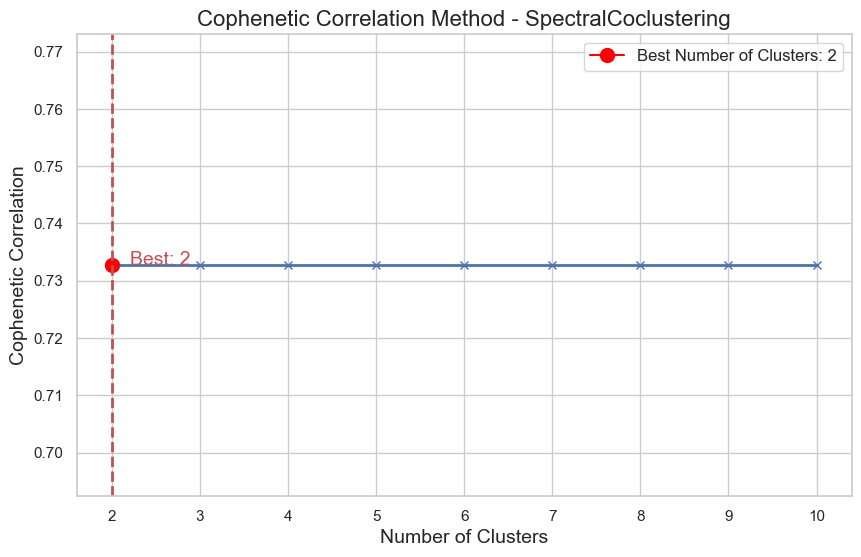

In [34]:
# Test fine tuning
best = fine_tune_algo(cluster_name='SpectralCoclustering', methods=methods, data=df, n_iter=10, show=True)
print(best)


Fine tuning KMeans algorithm...
Performing tuning with the following methods:
['Elbow', 'Silhouette', 'Gap Statistic', 'Explained Variance']
Performing tuning with Elbow method...
Performing tuning with Silhouette method...
Performing automatic tuning with random search for 10 iterations using Gap Statistic method...
Performing tuning with Explained Variance method...
Performing automatic tuning with random search for 10 iterations using the best cluster number (4) from previous tuning methods...
Fine tuning AgglomerativeClustering algorithm...
Performing tuning with the following methods:
['Elbow', 'Silhouette', 'Gap Statistic']
Performing tuning with Elbow method...
Performing tuning with Silhouette method...
Performing automatic tuning with random search for 10 iterations using Gap Statistic method...
Performing automatic tuning with random search for 10 iterations using the best cluster number (7) from previous tuning methods...
Fine tuning SpectralClustering algorithm...
Performin

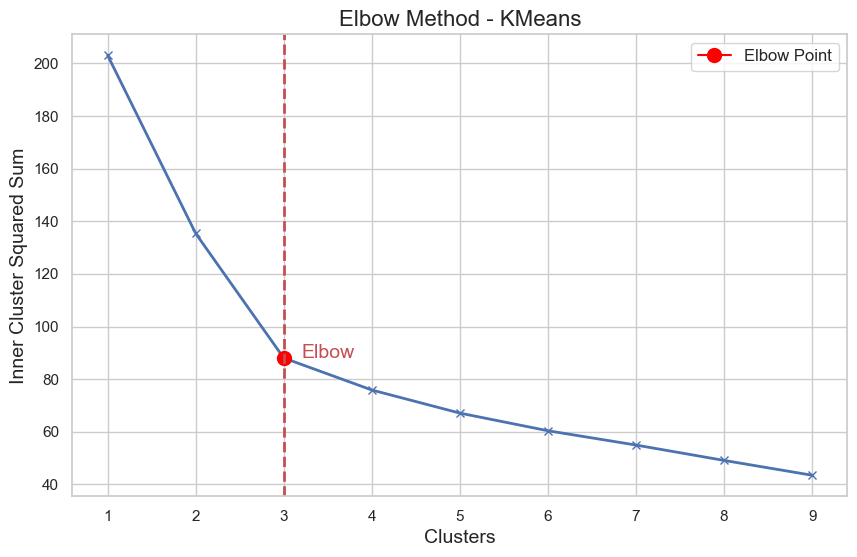

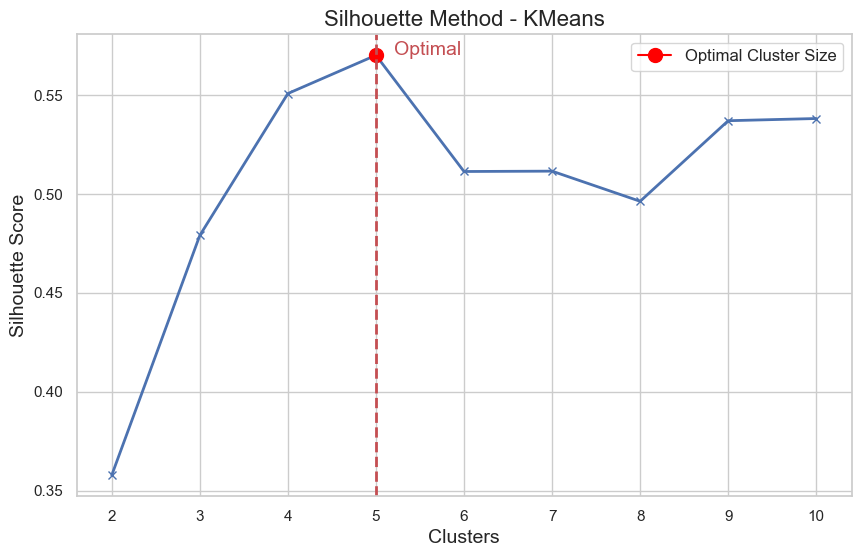

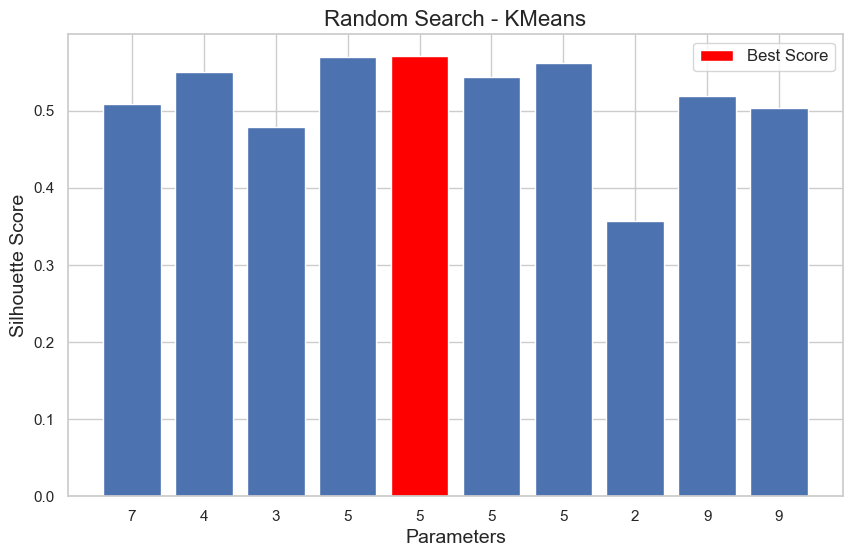

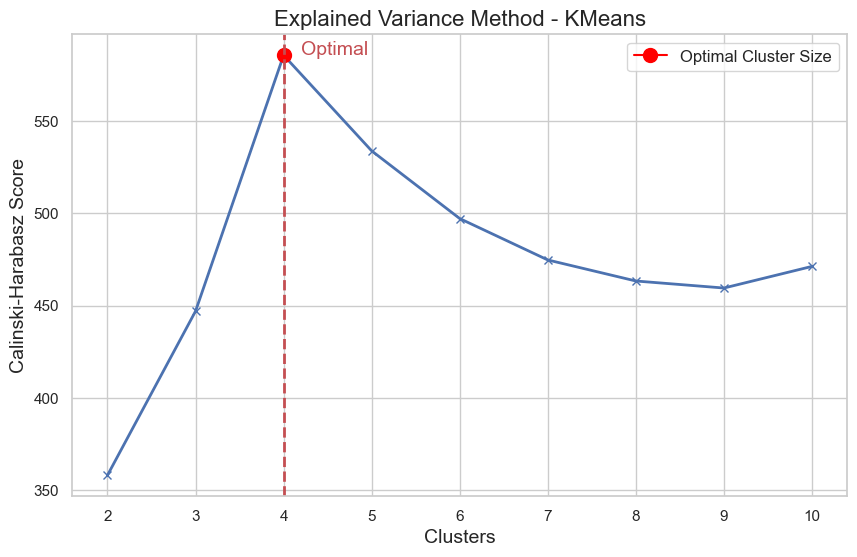

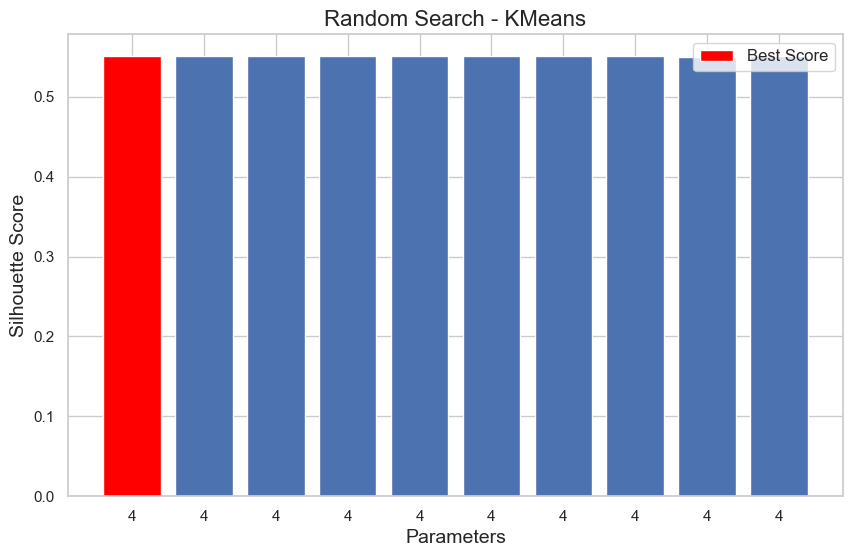

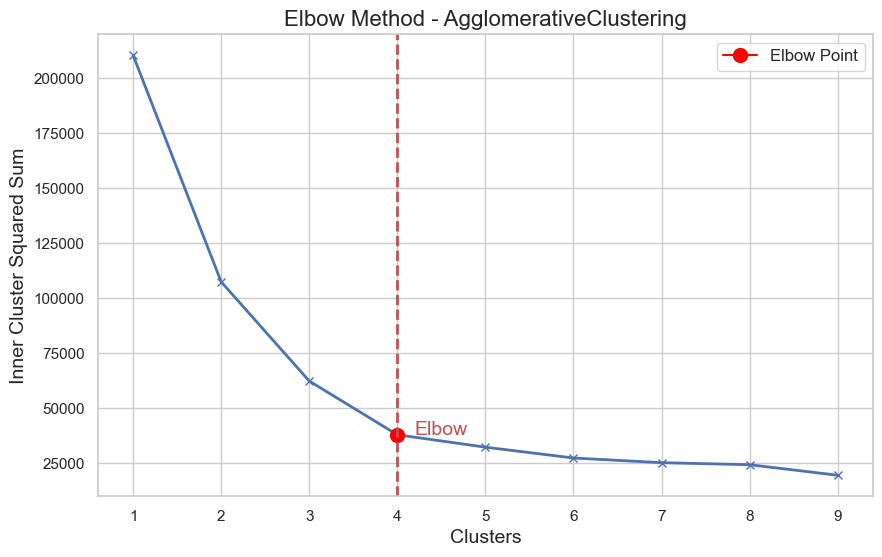

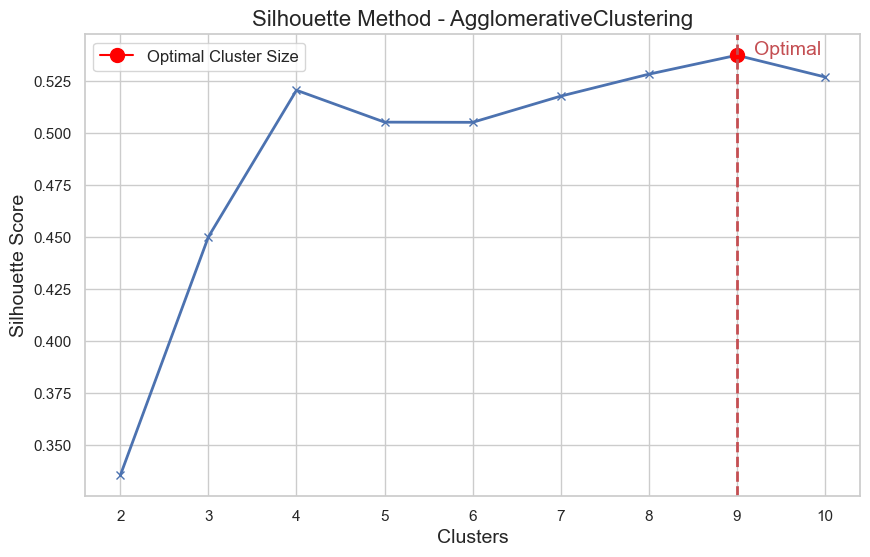

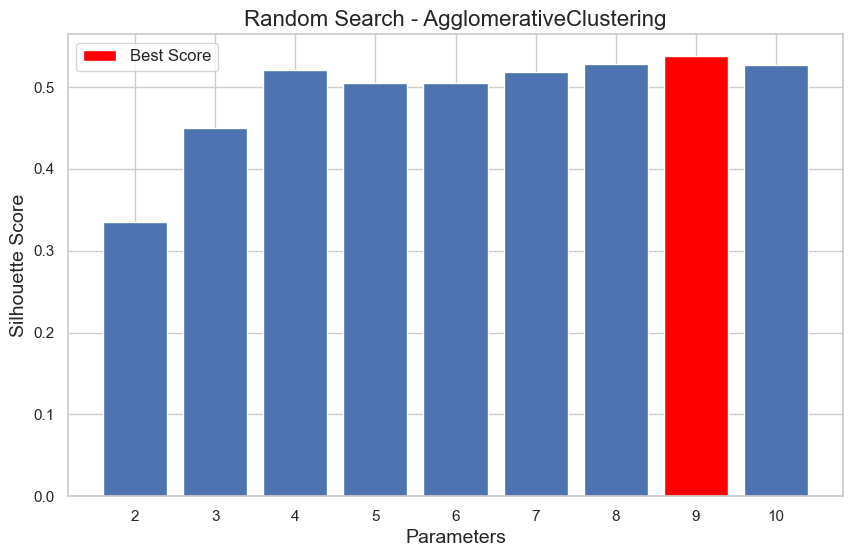

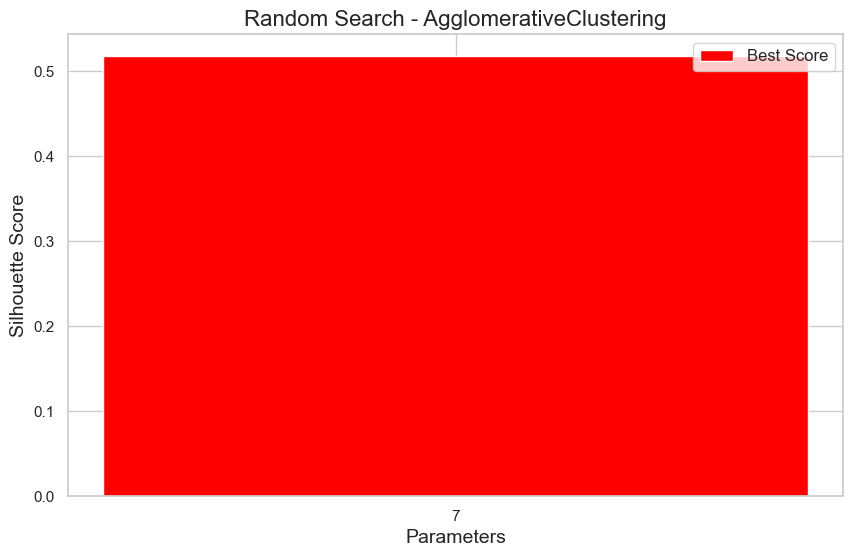

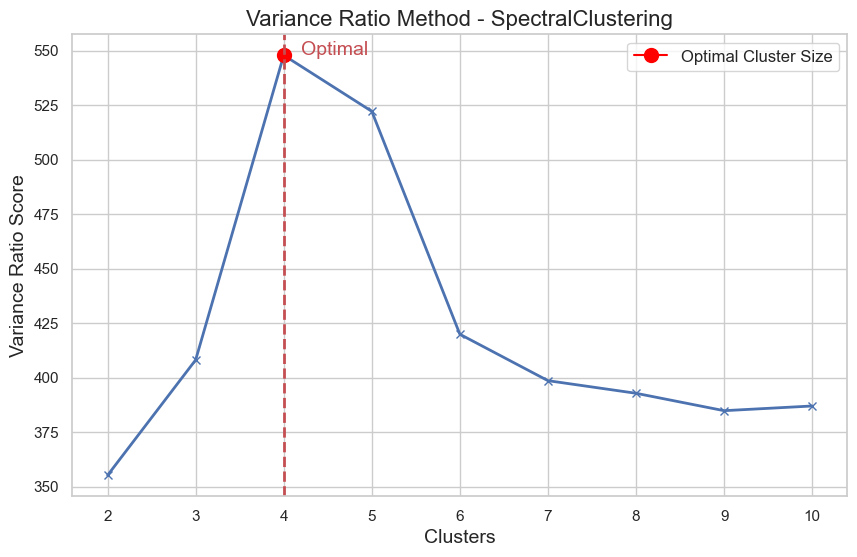

Performing automatic tuning with random search for 10 iterations using Gap Statistic method...
Performing automatic tuning with random search for 10 iterations using the best cluster number (4) from previous tuning methods...
Fine tuning Birch algorithm...
Performing tuning with the following methods:
['Elbow', 'Explained Variance']
Performing tuning with Elbow method...
Performing tuning with Explained Variance method...
Performing automatic tuning with random search for 10 iterations using the best cluster number (6) from previous tuning methods...
Fine tuning MiniBatchKMeans algorithm...
Performing tuning with the following methods:
['Elbow', 'Silhouette', 'Gap Statistic', 'Explained Variance']
Performing tuning with Elbow method...
Performing tuning with Silhouette method...
Performing automatic tuning with random search for 10 iterations using Gap Statistic method...
Performing tuning with Explained Variance method...
Performing automatic tuning with random search for 10 iteration

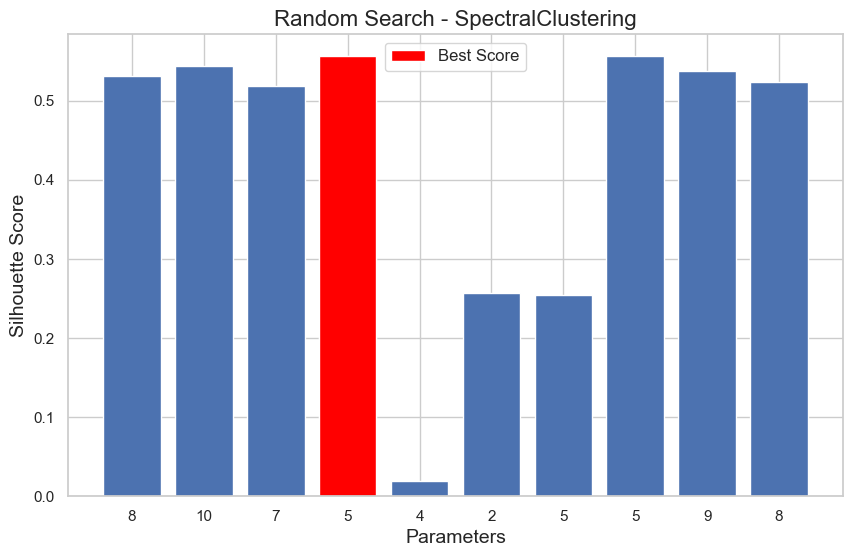

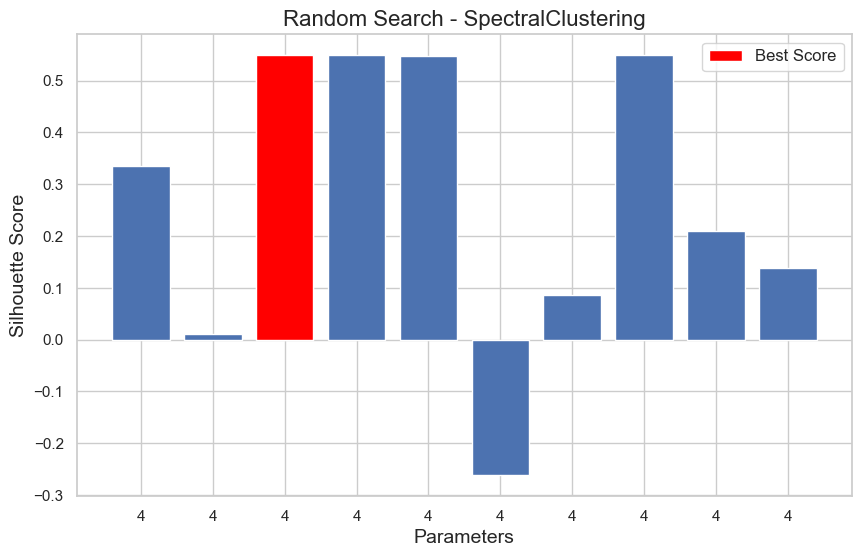

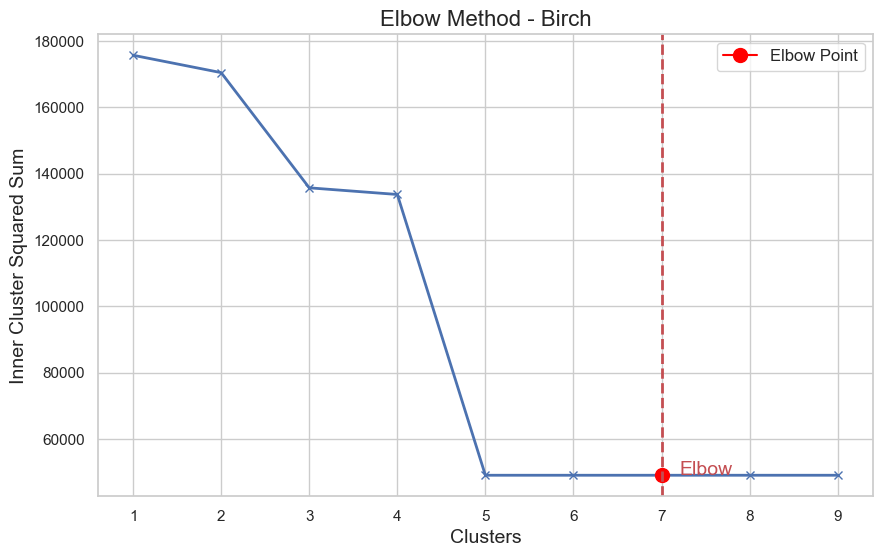

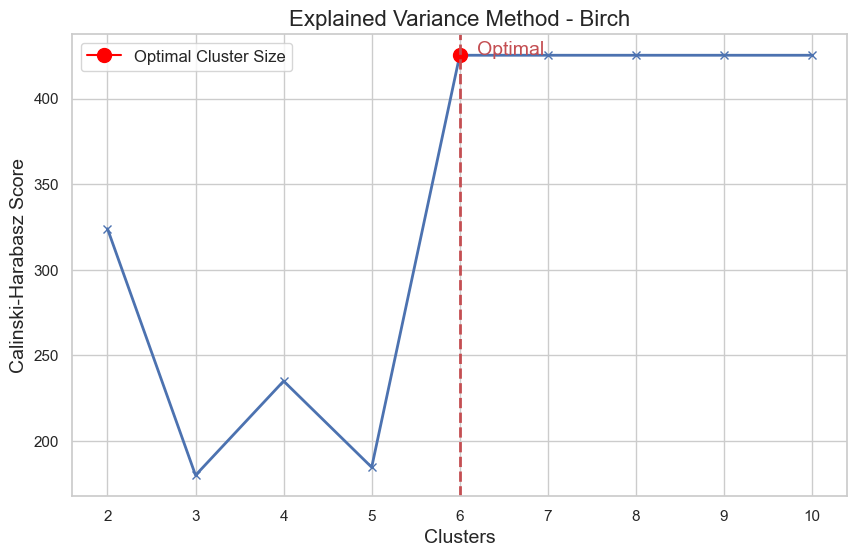

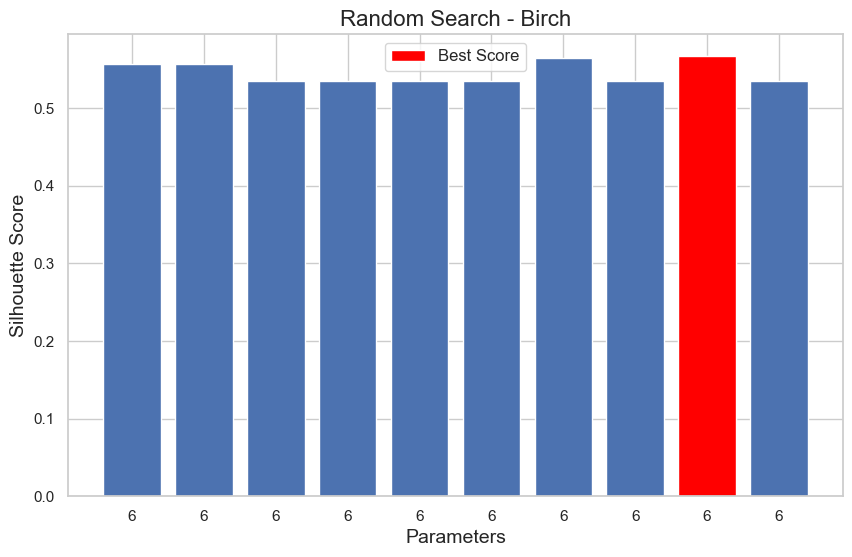

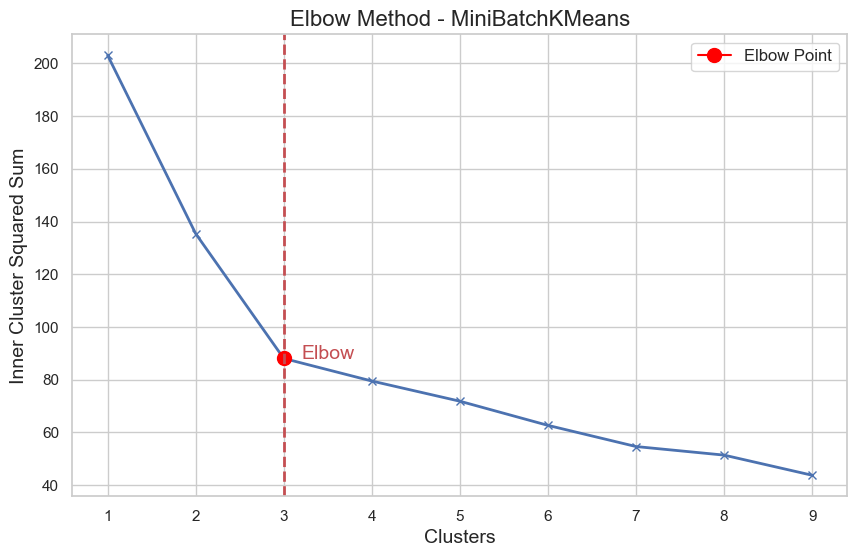

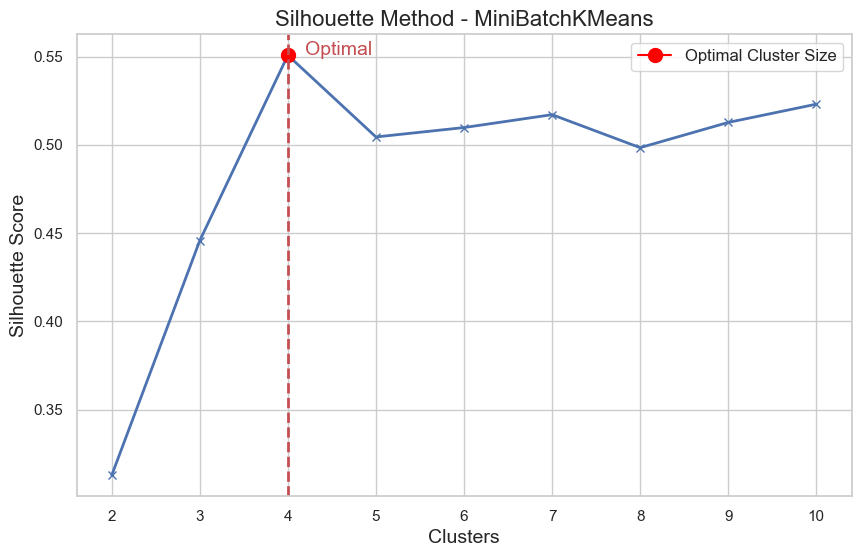

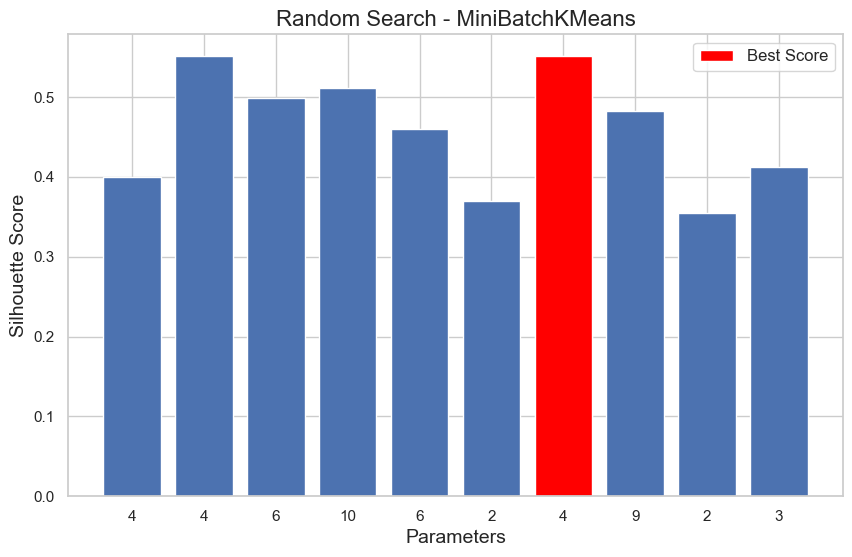

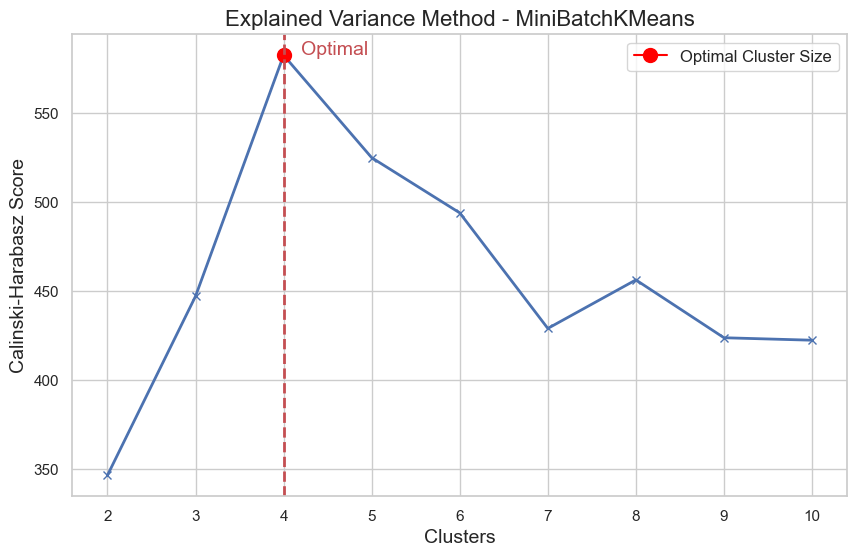

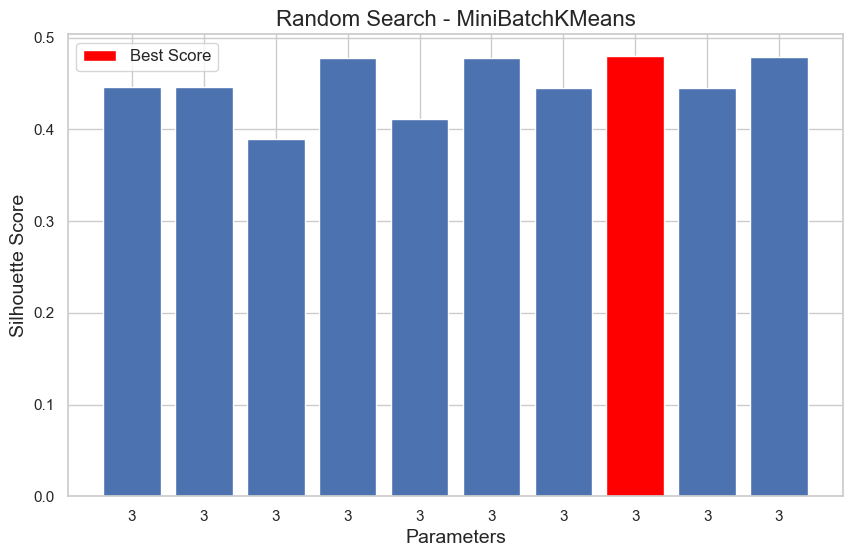

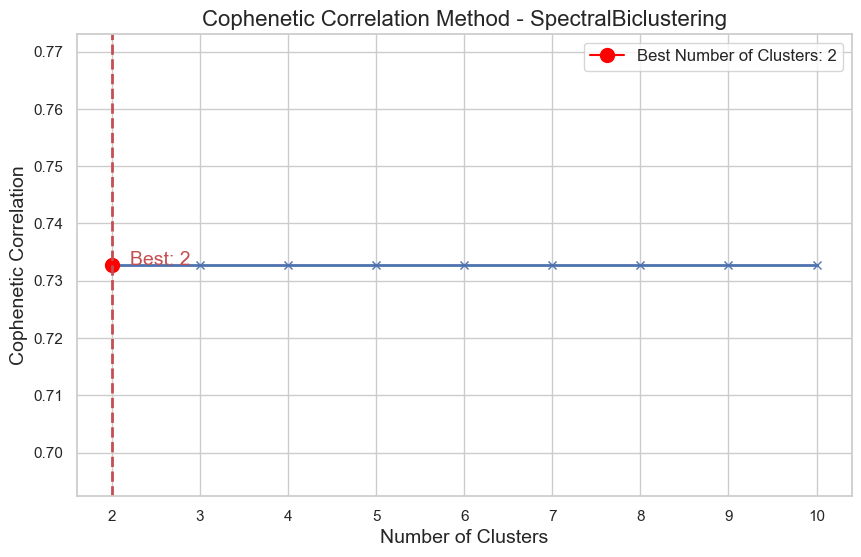

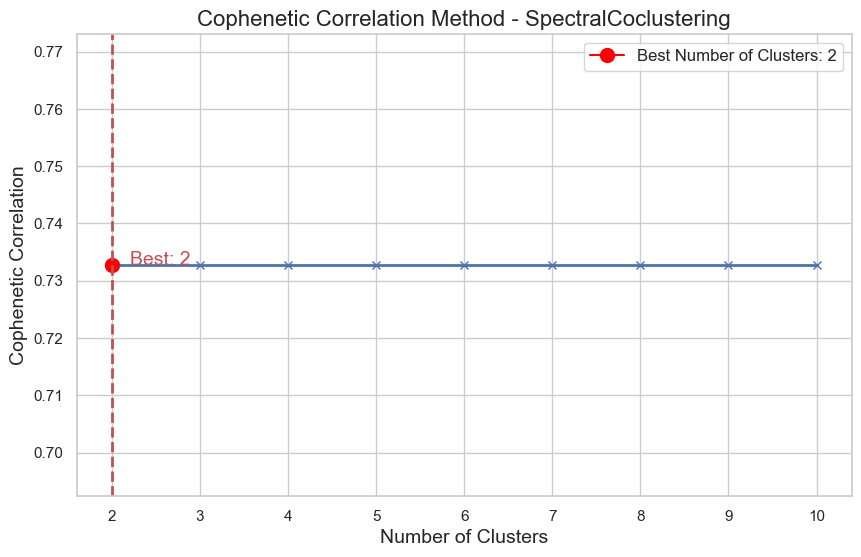

In [37]:
# fine tuning each algorithm
best_params = {}
for algo in clusters:
    try:
        best_params[algo] = fine_tune_algo(cluster_name=algo, methods=methods, data=df, n_iter=10, show=True)
    except Exception as e:
        best_params[algo] = f'Failed -> {e}'

In [38]:
pp(best_params)

{'AgglomerativeClustering': {'affinity': 'euclidean',
                             'linkage': 'ward',
                             'n_clusters': 7},
 'Birch': {'branching_factor': 40, 'n_clusters': 6, 'threshold': 0.1},
 'FeatureAgglomeration': 'Failed -> Item wrong length 20 instead of 718.',
 'KMeans': {'algorithm': 'full',
            'init': 'k-means++',
            'max_iter': 400,
            'n_clusters': 4,
            'tol': 0.0001},
 'MiniBatchKMeans': {'batch_size': 60,
                     'init': 'k-means++',
                     'max_iter': 250,
                     'n_clusters': 3,
                     'tol': 0.0001},
 'SpectralBiclustering': "Failed -> 'SpectralBiclustering' object has no "
                         "attribute 'labels_'",
 'SpectralClustering': {'affinity': 'rbf',
                        'gamma': 0.001,
                        'n_clusters': 4,
                        'n_neighbors': 8},
 'SpectralCoclustering': "Failed -> 'SpectralCoclustering' object has

In [36]:
#Iterate over clusters and create folder in images
import os
for i in clusters:
    os.mkdir(f'images/'+i)

In [ ]:

#mormalisation
features = clothes_df.iloc[:, -4:]


#KMean
kmeans = KMeans()
elbow_point = auto_elbow(kmeans, df, 15)
kmeans = KMeans(n_clusters=elbow_point)
kmeans.fit(features)
predictions = kmeans.predict(features)
clothes_df["KMeanCluster"] = predictions

#DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(features)
predictions = dbscan.labels_
clothes_df["DbscanCluster"] = predictions

#GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(features)
predictions = gmm.predict(features)
clothes_df["GMCluster"] = predictions

# Agglomerative Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=2, linkage="ward")
predictions = agg_clustering.fit_predict(features)
clothes_df["AggCluster"] = predictions

# Spectral Clustering
spectral_clustering = SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
predictions = spectral_clustering.fit_predict(features)
clothes_df["SpectralCluster"] = predictions

# OPTICS
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)
predictions = optics.fit_predict(features)
clothes_df["OpticsCluster"] = predictions

# Mean Shift Clustering
mean_shift = MeanShift(bandwidth=None, bin_seeding=True)
predictions = mean_shift.fit_predict(features)
clothes_df["MeanShiftCluster"] = predictions

# Affinity Propagation
affinity_propagation = AffinityPropagation(random_state=42)
predictions = affinity_propagation.fit_predict(features)
clothes_df["AffinityPropCluster"] = predictions

# Birch
birch = Birch(n_clusters=2, threshold=0.5, branching_factor=50)
predictions = birch.fit_predict(features)
clothes_df["BirchCluster"] = predictions

# Self-Organizing Map
som_grid_rows, som_grid_columns = 2, 2
som = MiniSom(som_grid_rows, som_grid_columns, features.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)
som.train_random(features, num_iteration=1000)
predictions = [som.winner(x) for x in features]
clothes_df["SOMCluster"] = predictions

# HDBSCAN
hdbscan_cluster = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
predictions = hdbscan_cluster.fit_predict(features)
clothes_df["HDBSCANCluster"] = predictions





In [ ]:
#Audi cluster
def ultimate_clustered(cluster):
    print(f'{cluster} en cours')
    
    print(f'generation des plots')
    sns.set(style="ticks", color_codes=True)
    sns.pairplot(data=clothes_df, vars=['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], hue=cluster, diag_kind='hist')
    plt.savefig(f"images/{cluster.replace('Cluster','')}_pairplot.png", dpi=300)
    
    fig = go.Figure()
    for i in range(len(clothes_df[cluster].unique())):
        cluster_df = clothes_df[clothes_df[cluster] == i]
        fig.add_trace(go.Scatterpolar(
            r=cluster_df.mean()[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']].tolist(),
            theta=['Environmental Impact', 'Animal Welfare', 'Human Welfare', 'Social Responsibility'],
            fill='toself',
            name=f'Cluster {i}'
        ))
    fig.update_layout(
        polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 10]
        )),
        showlegend=True
    )
    print(f"images/{cluster.replace('Cluster','')}_radar.png")
    fig.write_image(f"images/{cluster.replace('Cluster','')}_radar.png")
    fig.show()
    
    kmeans_means = clothes_df.groupby(cluster).mean()[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']]
    kmeans_means.plot(kind='bar')
    plt.title(f'Mean KPI Scores by {cluster}')
    plt.savefig(f"images/{cluster.replace('Cluster','')}_histo.png", dpi=300)

    


clusters = ['KMeanCluster', 'DbscanCluster', 'GMCluster', 'AggCluster', 'SpectralCluster', 'SpectralCluster', 'OpticsCluster', 'MeanShiftCluster', 'AffinityPropCluster', 'BirchCluster', 'SOMCluster', 'HDBSCANCluster']
cluster = clusters[3]
ultimate_clustered(cluster)

In [ ]:
# Intern KPI of cluster
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Génération de données pour l'exemple
X, y = make_blobs(n_samples=500, centers=4, random_state=42)

# Exemple de clustering avec KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
y_pred = kmeans.fit_predict(X)

# Calcul du coefficient de silhouette
silhouette_avg = silhouette_score(X, y_pred)
silhouette_indicator = "bon" if silhouette_avg > 0.5 else "mauvais"
print(f"Coefficient de silhouette : {silhouette_avg} ({silhouette_indicator})")

# Calcul de l'indice de Davies-Bouldin
dbi = davies_bouldin_score(X, y_pred)
dbi_indicator = "bon" if dbi < 0.5 else "mauvais"
print(f"Indice de Davies-Bouldin : {dbi} ({dbi_indicator})")

# Calcul de l'indice de Calinski-Harabasz
ch_score = calinski_harabasz_score(X, y_pred)
ch_indicator = "bon" if ch_score > (len(X) / 2) else "mauvais"
print(f"Indice de Calinski-Harabasz : {ch_score} ({ch_indicator})")

#Nethode elbow
#kullerback 
# Attribution d'un score global au modèle en se basant sur les 3 méthodes
total_score = (
    (silhouette_avg - 0.5) / 0.5 +
    (1 - dbi) +
    (ch_score - len(X) / 2) / (len(X) / 2)
)
total_score /= 3
print(f"Score global du modèle : {total_score}")


In [ ]:
# Get non null kpi data
nonzero_rows = clothes_df[
    (clothes_df['Environmental Impact Score'] != 0.00) |
    (clothes_df['Animal Welfare Score'] != 0.00) |
    (clothes_df['Human Welfare Score'] != 0.00) |
    (clothes_df['Social Responsibility Score'] != 0.00)
]

# Print the selected rows, along with the other columns
print(nonzero_rows[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score', cluster]].head(600).to_csv(index=False))


In [ ]:
#PairPlot

sns.set(style="ticks", color_codes=True)
sns.pairplot(data=clothes_df, vars=['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score'], hue=cluster, diag_kind='hist')


In [ ]:
#Radar

fig = go.Figure()
def radar(cluster):
  for i in range(len(clothes_df[cluster].unique())):
      cluster_df = clothes_df[clothes_df[cluster] == i]
      fig.add_trace(go.Scatterpolar(
          r=cluster_df.mean()[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']].tolist(),
          theta=['Environmental Impact', 'Animal Welfare', 'Human Welfare', 'Social Responsibility'],
          fill='toself',
          name=f'Cluster {i}'
      ))

  fig.update_layout(
    polar=dict(
      radialaxis=dict(
        visible=True,
        range=[0, 10]
      )),
    showlegend=True
  )

  fig.show()

radar(cluster)
#radar('DbscanCluster')
#radar('GMCluster')


In [ ]:
#Bars

# Bar plot of mean KPI scores by cluster
kmeans_means = clothes_df.groupby(cluster).mean()[['Environmental Impact Score', 'Animal Welfare Score', 'Human Welfare Score', 'Social Responsibility Score']]
kmeans_means.plot(kind='bar')
plt.title(f'Mean KPI Scores by {cluster}')
plt.show()
